**Importing all the necessary libraries**

In [1]:
!pip install nilearn

     |████████████████████████████████| 4.9 MB 13.4 MB/s 


In [2]:
# General
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# fMRI specific
from nilearn import datasets
from nilearn.input_data import NiftiMasker
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, roc_auc_score
from nilearn.plotting import plot_matrix, show 

# ML specific
from sklearn.feature_selection import SelectKBest, f_classif 
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier 
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict, KFold, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier 


# For downloading
from google.colab import files

/usr/local/lib/python3.7/dist-packages/nilearn/datasets/__init__.py:89: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


**Download data set**

In [3]:
# Initilizing empty variables for the acc

# Accuracies per fold
svc_ovo_avg = []
svc_ova_avg = []
log_ovo_avg = []
log_ova_avg = []

# Accuracies on participant level
participant_level_svc_ovo = []
participant_level_svc_ova = []
participant_level_log_ovo = []
participant_level_log_ova = []

# Confusion Matrix
grant_cm_svc_ovo = []
grant_cm_svc_ova = []
grant_cm_log_ovo = []
grant_cm_log_ova = []

# Data set for the first 4
haxby_dataset = datasets.fetch_haxby(subjects = [1,2,3,4])


Dataset created in /root/nilearn_data/haxby2001



 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


Downloaded 313188352 of 314803244 bytes (99.5%,    0.1s remaining) ...done. (11 seconds, 0 min)
Extracting data from /root/nilearn_data/haxby2001/570d0f0e6c7d7f94134c45241f118313/subj1-2010.01.14.tar.gz..... done.


Downloaded 277585920 of 291168628 bytes (95.3%,    0.5s remaining) ...done. (11 seconds, 0 min)
Extracting data from /root/nilearn_data/haxby2001/570d0f0e6c7d7f94134c45241f118313/subj2-2010.01.14.tar.gz..... done.


Downloaded 278437888 of 296936090 bytes (93.8%,    0.7s remaining) ...done. (11 seconds, 0 min)
Extracting data from /root/nilearn_data/haxby2001/570d0f0e6c7d7f94134c45241f118313/subj3-2010.01.14.tar.gz..... done.


Downloaded 303652864 of 329954386 bytes (92.0%,    1.0s remaining) ...done. (12 seconds, 0 min)
Extracting data from /root/nilearn_data/haxby2001/570d0f0e6c7d7f94134c45241f118313/subj4-2010.01.14.tar.gz..... done.


**Training Models**

**1.A**: Compare performance of a multinomial logistic regression with a linear SVM
either using one-vs-rest or a one-vs-one multi class classification. Make a graph that shows the
mean decoding accuracy for each approach and the variability between subjects.

In [ ]:
# Loop for all 4 participants 

# Models 
clf_svc = make_pipeline(StandardScaler(), svm.LinearSVC(C=1., penalty='l2',
                        multi_class='ovr', max_iter=5000, class_weight='balanced'))
clf_log = make_pipeline(StandardScaler(), LogisticRegression(C=1., penalty='l2',
                    multi_class='multinomial', max_iter=5000, class_weight='balanced'))
# SVC
svc_ovo = OneVsOneClassifier(clf_svc)
svc_ova = OneVsRestClassifier(clf_svc)

# Log
log_ovo = OneVsOneClassifier(clf_log)
log_ova = OneVsRestClassifier(clf_log)

for sub in list(range(0,4)):
  func_filename = haxby_dataset.func[sub]
  mask_filename = haxby_dataset.mask

  # Load the behavioral data that we will predict
  labels = pd.read_csv(haxby_dataset.session_target[sub], sep=" ")
  y = labels['labels']
  session = labels['chunks']

  # Remove the rest condition, it is not very interesting
  non_rest = (y != 'rest')
  y = y[non_rest]

  # Get the labels of the numerical conditions represented by the vector y
  unique_conditions, order = np.unique(y, return_index=True)
  # Sort the conditions by the order of appearance
  unique_conditions = unique_conditions[np.argsort(order)]

  # For decoding, standardizing is often very important

  nifti_masker2 = NiftiMasker(standardize=True, runs=session, detrend=True,
                mask_strategy='epi', smoothing_fwhm=4, high_pass=1/128, t_r=2.5)
  
  X = nifti_masker2.fit_transform(func_filename)

  # Remove the "rest" condition
  X = X[non_rest]
  session = session[non_rest]

  fold_acc_svc_ovo = np.empty([len(np.unique(session))])
  fold_acc_svc_ova = np.empty([len(np.unique(session))])
  fold_acc_log_ovo = np.empty([len(np.unique(session))])
  fold_acc_log_ova = np.empty([len(np.unique(session))])

  for cfold in range(0, (len(np.unique(session)))):

    # SVC (ovo vs ova)
    test_data = X[np.where(session == cfold)[0], :]
    test_labels = y[session == cfold]
    train_data = X[np.where(session != cfold)[0], :]
    train_labels = y[session != cfold]
    cclf_svc_ovo = svc_ovo.fit(train_data, train_labels)
    cclf_svc_ova = svc_ova.fit(train_data, train_labels)
    predictions_svc_ovo = cclf_svc_ovo.predict(test_data)
    predictions_svc_ova = cclf_svc_ova.predict(test_data)
    fold_acc_svc_ova[cfold] = cclf_svc_ova.score(test_data, test_labels)
    fold_acc_svc_ovo[cfold] = cclf_svc_ovo.score(test_data, test_labels)


    cm_svc_ovo = confusion_matrix(test_labels, predictions_svc_ovo, labels=cclf_svc_ovo.classes_, 
                            normalize='true')
    cm_svc_ova = confusion_matrix(test_labels, predictions_svc_ova, labels=cclf_svc_ova.classes_, 
                            normalize='true')

    locals()['SVMmatrix_ovo' + str(cfold) + str(sub)] = cm_svc_ovo
    locals()['SVMmatrix_ova' + str(cfold) + str(sub)] = cm_svc_ova
    print('Fold (SVC): {0:3d}'.format(cfold), end='')
    print(' | {0:6.2f}'.format(fold_acc_svc_ovo[cfold]*100), end='%')
    print(' | {0:6.2f}'.format(fold_acc_svc_ova[cfold]*100), end='%')
    print(' | Done!')
    

  
   # Log (ovo vs ova)
    cclf_log_ovo = log_ovo.fit(train_data, train_labels)
    cclf_log_ova = log_ova.fit(train_data, train_labels)
    predictions_log_ovo = cclf_log_ovo.predict(test_data)
    predictions_log_ova = cclf_log_ova.predict(test_data)
    fold_acc_log_ova[cfold] = cclf_log_ova.score(test_data, test_labels)
    fold_acc_log_ovo[cfold] = cclf_log_ovo.score(test_data, test_labels)

    cm_log_ovo = confusion_matrix(test_labels, predictions_log_ovo, labels=cclf_log_ovo.classes_, 
                            normalize='true')
    cm_log_ova = confusion_matrix(test_labels, predictions_log_ova, labels=cclf_log_ova.classes_, 
                            normalize='true')
    
    grant_cm_svc_ovo.append(cm_svc_ovo)
    grant_cm_svc_ova.append(cm_svc_ova)
    grant_cm_log_ovo.append(cm_log_ovo)
    grant_cm_log_ova.append(cm_log_ova)

    locals()['LOGmatrix_ovo' + str(cfold) + str(sub)] = cm_log_ovo
    locals()['LOGmatrix_ova' + str(cfold) + str(sub)] = cm_log_ova
    print('Fold (LOG): {0:3d}'.format(cfold), end='')
    print(' | {0:6.2f}'.format(fold_acc_log_ovo[cfold]*100), end='%')
    print(' | {0:6.2f}'.format(fold_acc_log_ova[cfold]*100), end='%')
    print(' | Done!')

    svc_ovo_avg.append(fold_acc_svc_ovo[cfold])
    svc_ova_avg.append(fold_acc_svc_ova[cfold])
  

    log_ovo_avg.append(fold_acc_log_ovo[cfold])
    log_ova_avg.append(fold_acc_log_ova[cfold])



  participant_level_svc_ovo.append(fold_acc_svc_ovo.mean())
  participant_level_svc_ova.append(fold_acc_svc_ova.mean())
  participant_level_log_ovo.append(fold_acc_log_ovo.mean())
  participant_level_log_ova.append(fold_acc_log_ova.mean())
          
 
accuracies_folds = pd.DataFrame()
accuracies_folds['svc_ovo'] = svc_ovo_avg
accuracies_folds['svc_ova'] = svc_ova_avg
accuracies_folds['log_ovo'] = log_ovo_avg
accuracies_folds['log_ova'] = log_ova_avg

accuracies_participants = pd.DataFrame()
accuracies_participants['svc_ovo'] = participant_level_svc_ovo
accuracies_participants['svc_ova'] = participant_level_svc_ova
accuracies_participants['log_ovo'] = participant_level_log_ovo
accuracies_participants['log_ova'] = participant_level_log_ova





<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

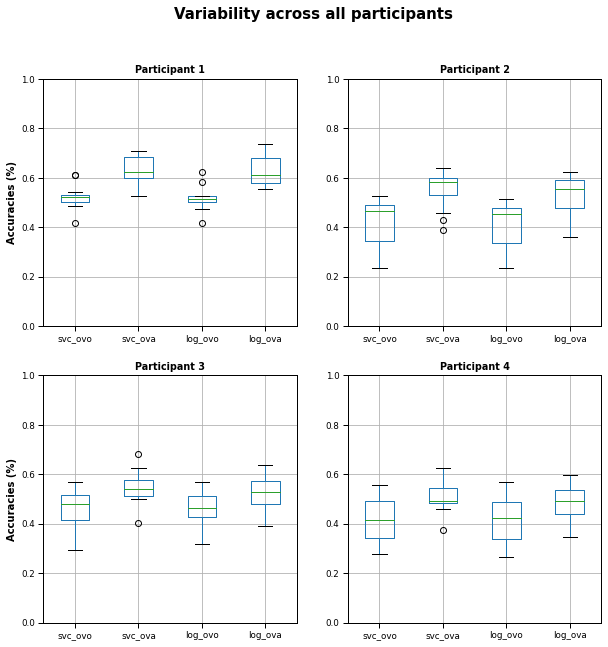

In [ ]:
import seaborn as sns
sns.set_context("paper")

#p1's acc are put twice, because my loop failed but then I forgot to empty the variables as they are in another cell
p1 = accuracies_folds[12:24]
p2 = accuracies_folds[24:36]
p3 = accuracies_folds[36:48]
p4 = accuracies_folds[48:60]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
fig.suptitle("Variability across all participants", fontsize = 15, fontweight='bold')

ax1 = p1.boxplot(ax=axes[0,0])
ax1.set_ylim(0,1.0)
ax1.set_ylabel("Accuracies (%)", fontsize=10, fontweight='bold')
ax1.set_title('Participant 1',fontweight='bold')


ax2 = p2.boxplot(ax=axes[0,1])
ax2.set_ylim(0,1.0)
ax2.set_title('Participant 2',fontweight='bold')

ax3 = p3.boxplot(ax=axes[1,0])
ax3.set_ylim(0,1.0)
ax3.set_ylabel("Accuracies (%)", fontsize=10, fontweight='bold')
ax3.set_title('Participant 3',fontweight='bold')

ax4 = p4.boxplot(ax=axes[1,1])
ax4.set_ylim(0,1.0)
ax4.set_title('Participant 4',fontweight='bold')

plt.savefig("par_var.png")
files.download("par_var.png")

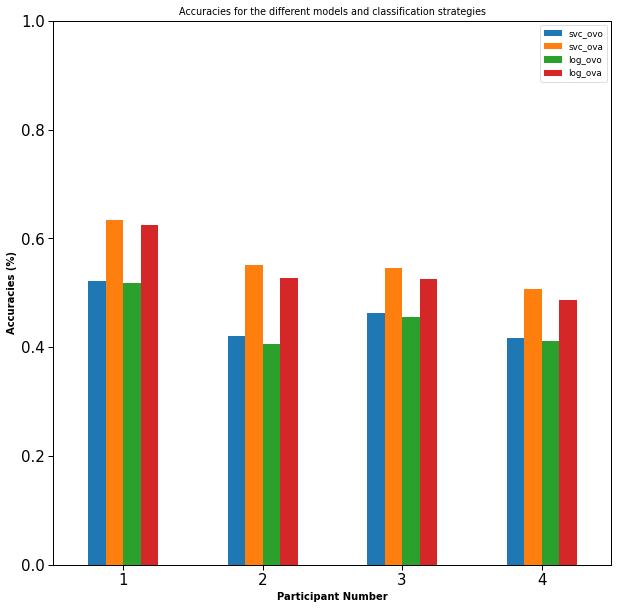

In [ ]:
ax = accuracies_participants.plot.bar(figsize=[10,10], title = "Accuracies for the different models and classification strategies", fontsize = 15)
ax.set_xticklabels([1,2,3,4], rotation=0)
ax.set_ylim(0,1.0)
ax.set_ylabel("Accuracies (%)", fontsize=10, fontweight='bold')
ax.set_xlabel("Participant Number", fontsize=10, fontweight='bold')
plt.savefig("plot_accuracies.png")
#files.download("plot_accuracies.png")

In [ ]:
from google.colab import files
np.save('accuracies_folds.npy', accuracies_folds)
files.download("accuracies_folds.npy")

np.save('participants_accuracies.npy', accuracies_participants)
files.download("participants_accuracies.npy")




<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Creating confusion matreces**  
**1. B**: Please report the decoding accuracy (percent true positives) for the individual
classes and make a corresponding gure. Can some classes be decoded better than others?

In [ ]:
# Turning matrices into np.arrays
grant_cm_svc_ovo = np.array(grant_cm_svc_ovo)
grant_cm_svc_ova = np.array(grant_cm_svc_ova)
grant_cm_log_ovo = np.array(grant_cm_log_ovo)
grant_cm_log_ova = np.array(grant_cm_log_ova)

np.save('grant_cm_svc_ovo.npy', grant_cm_svc_ovo)
files.download("grant_cm_svc_ovo.npy")

np.save('grant_cm_svc_ova.npy', grant_cm_svc_ova)
files.download("grant_cm_svc_ova.npy")

np.save('grant_cm_log_ovo.npy', grant_cm_log_ovo)
files.download("grant_cm_log_ovo.npy")

np.save('grant_cm_log_ova.npy', grant_cm_log_ova)
files.download("grant_cm_log_ova.npy")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

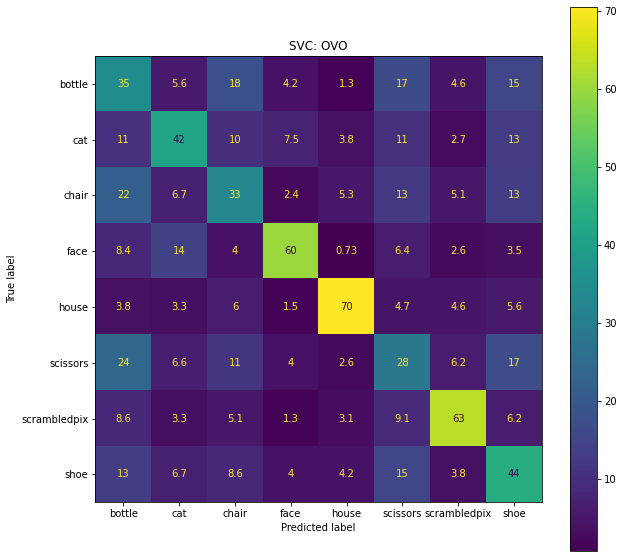

In [ ]:
# SVC OVO
disp_svc_ovo = ConfusionMatrixDisplay(confusion_matrix=grant_cm_svc_ovo.mean(axis=0)*100, 
                              display_labels=cclf_svc_ovo.classes_)
fig, ax = plt.subplots(figsize=(10,10))
disp_svc_ovo.plot(ax=ax)
plt.title('SVC: OVO')

plt.savefig("disp_svc_ovo.png")
files.download("disp_svc_ovo.png")

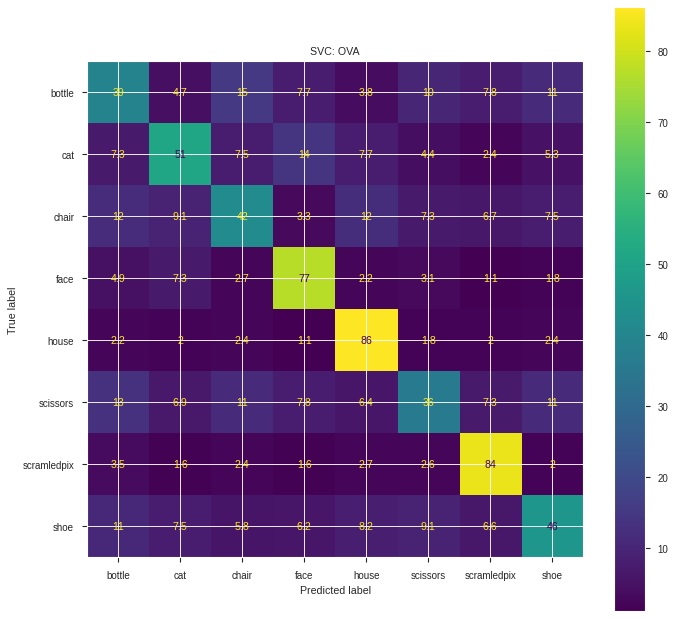

In [76]:
# SVC OVA
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
grant_cm_svc_ova = np.load('grant_cm_svc_ova.npy')
# SVC OVA
labels = ['bottle', 'cat', 'chair', 'face', 'house', 'scissors', 'scramledpix', 'shoe']
disp_svc_ova = ConfusionMatrixDisplay(confusion_matrix=grant_cm_svc_ova.mean(axis=0)*100, 
                              display_labels = labels)

fig, ax = plt.subplots(figsize=(10,10))
disp_svc_ova.plot(ax = ax)
plt.title('SVC: OVA')

plt.savefig("disp_svc_ova.png")
#files.download("disp_svc_ova.png")



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

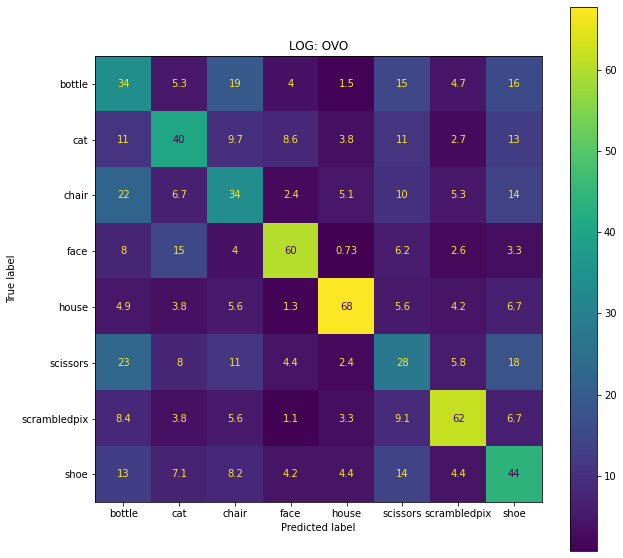

In [ ]:
# LOG OVO 
disp_log_ovo = ConfusionMatrixDisplay(confusion_matrix=grant_cm_log_ovo.mean(axis=0)*100, 
                              display_labels=cclf_log_ovo.classes_)

fig, ax = plt.subplots(figsize=(10,10))
disp_log_ovo.plot(ax = ax)
plt.title('LOG: OVO')

plt.savefig("disp_log_ovo.png")
files.download("disp_log_ovo.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

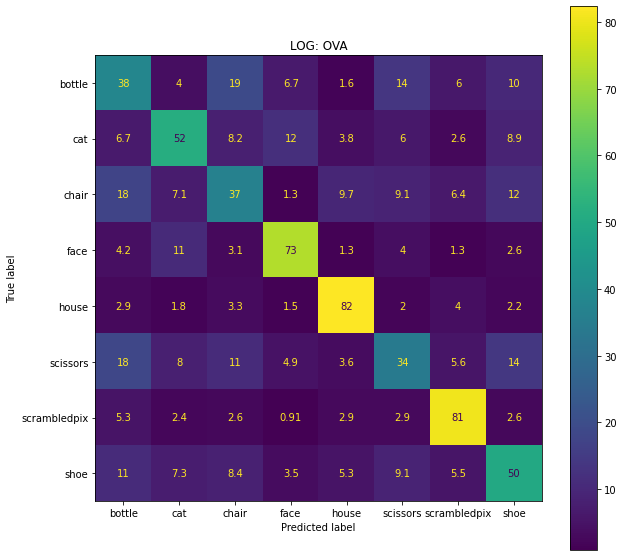

In [ ]:
# LOG OVA 
disp_log_ova = ConfusionMatrixDisplay(confusion_matrix=grant_cm_log_ova.mean(axis=0)*100, 
                              display_labels=cclf_log_ova.classes_)

fig, ax = plt.subplots(figsize=(10,10))
disp_log_ova.plot(ax = ax)
plt.title('LOG: OVA')

plt.savefig("disp_log_ova.png")
files.download("disp_log_ova.png")

In [ ]:
mean_cm = grant_cm_svc_ova.mean(axis=0)
# recall score
recall = np.diag(mean_cm) / np.sum(mean_cm, axis = 1) # axis 1 means column values
print(recall)

# mean of recall
mr = np.mean(recall)
print(mr)

# precision score
precision = np.diag(mean_cm) / np.sum(mean_cm, axis = 0) # axis 0 means row values
print(precision)

mr2 = np.mean(precision)
print(mr2)

# F1 score
F1 = 2 * (precision * recall) / (precision + recall)
print(F1)

# mean of F1 score
F1 = np.mean(F1)
print(F1)

**Nested cross validation scheme**   
**1.C**: Using a linear SVM and the multi-class approach that worked best in a), set up
a nested cross validation scheme in which you find the best C parameter, and then decode
using that C. Please submit your code of the nested cross validation. You can use any function
that is part of nilearn or sklearn.


In [6]:
 
#Create arrays to store the scores (folds per participant: NOT FLEXIBLE ENOUGH)
outer_scores = np.zeros((12,4))
nested_scores = np.zeros((12,4))
acc_non_nested = np.zeros((12,4))
acc_nested = np.zeros((12,4))

best_models = []


#Loop dor each subject
for sub in range(4):
  func_filename = haxby_dataset.func[sub]
  mask_filename = haxby_dataset.mask

  # Load the behavioral data that we will predict
  labels = pd.read_csv(haxby_dataset.session_target[sub], sep=" ")
  y = labels['labels']
  session = labels['chunks']

  # Remove the rest condition, it is not very interesting
  non_rest = (y != 'rest')
  y = y[non_rest]

  # Get the labels of the numerical conditions represented by the vector y
  unique_conditions, order = np.unique(y, return_index=True)
  # Sort the conditions by the order of appearance
  unique_conditions = unique_conditions[np.argsort(order)]

  # For decoding, standardizing is often very important

  nifti_masker2 = NiftiMasker(standardize=True, runs=session, detrend=True,
                  mask_strategy='epi', smoothing_fwhm=4, high_pass=1/128, t_r=2.5)
    
  X = nifti_masker2.fit_transform(func_filename)

  # Remove the "rest" condition
  X = X[non_rest]
  session = session[non_rest]
 
  # Loop for each cfold 
  for cfold in range(0, (len(np.unique(session)))):
    # split data
    train_data = X[np.where(session == cfold )[0], :]
    train_labels = y[session == cfold]
    test_data = X[np.where(session != cfold)[0], :]
    test_labels = y[session != 10]


    #Define both cross-validation objects (inner & outer)
    inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1) 
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
      
    # define search space
    space = dict()
    space['C'] = [0.01, 0.1, 1, 10, 100]  

    # Non-nested parameter search and scoring
    clf = GridSearchCV(SVC(probability=True), space, scoring = 'roc_auc_ovr', cv=inner_cv)
    clf.fit(train_data, train_labels)
    print('Non-nested: Done!')
    outer_scores[cfold, sub] = clf.best_score_
    best_model_non = clf.best_estimator_
    best_models.append(clf.best_estimator_)

    # evaluate model on the hold out dataset
    yhat_non = best_model_non.predict(test_data)       
    # evaluate the model
    acc_non_nested[cfold, sub] = accuracy_score(test_labels, yhat_non)
    
      

    # Nested CV with parameter optimization
    nested_score = cross_val_score(clf, X=train_data, y=train_labels, cv=outer_cv)
    print('Nested: Done!')
    nested_scores[cfold, sub] = nested_score.mean()
    


Non-nested: Done!
Nested: Done!
Non-nested: Done!
Nested: Done!
Non-nested: Done!
Nested: Done!
Non-nested: Done!
Nested: Done!
Non-nested: Done!
Nested: Done!
Non-nested: Done!
Nested: Done!
Non-nested: Done!
Nested: Done!
Non-nested: Done!
Nested: Done!
Non-nested: Done!
Nested: Done!
Non-nested: Done!
Nested: Done!
Non-nested: Done!
Nested: Done!
Non-nested: Done!
Nested: Done!
Non-nested: Done!
Nested: Done!
Non-nested: Done!
Nested: Done!
Non-nested: Done!
Nested: Done!
Non-nested: Done!
Nested: Done!
Non-nested: Done!
Nested: Done!
Non-nested: Done!
Nested: Done!
Non-nested: Done!
Nested: Done!
Non-nested: Done!
Nested: Done!
Non-nested: Done!
Nested: Done!
Non-nested: Done!
Nested: Done!
Non-nested: Done!
Nested: Done!
Non-nested: Done!
Nested: Done!
Non-nested: Done!
Nested: Done!
Non-nested: Done!
Nested: Done!
Non-nested: Done!
Nested: Done!
Non-nested: Done!
Nested: Done!
Non-nested: Done!
Nested: Done!
Non-nested: Done!
Nested: Done!
Non-nested: Done!
Nested: Done!
Non-nest

In [ ]:
np.save('outer_scores.npy', outer_scores)
files.download("outer_scores.npy")

np.save('nested_scores.npy', nested_scores)
files.download("nested_scores.npy")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [7]:
best_models

[SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
     max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
     verbose=False),
 SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
     max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
     verbose=False),
 SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
     max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
     verbose=False),
 SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
     max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
     v

In [11]:
outer_scores[:,1]

array([0.93406593, 0.86777701, 0.77345467, 0.76486951, 0.68086081,
       0.82107372, 0.66634615, 0.77769002, 0.90978709, 0.65845925,
       0.91264881, 0.62501145])

In [12]:
score_difference1 = outer_scores[:,0] - nested_scores[:,0]

print("Avg. difference of {:6f} with std. dev. of {:6f}."
      .format(score_difference1.mean(), score_difference1.std()))

score_difference2 = outer_scores[:,1] - nested_scores[:,1]

print("Avg. difference of {:6f} with std. dev. of {:6f}."
      .format(score_difference2.mean(), score_difference2.std()))

score_difference3 = outer_scores[:,2] - nested_scores[:,2]

print("Avg. difference of {:6f} with std. dev. of {:6f}."
      .format(score_difference3.mean(), score_difference3.std()))

score_difference4 = outer_scores[:,3] - nested_scores[:,3]

print("Avg. difference of {:6f} with std. dev. of {:6f}."
      .format(score_difference4.mean(), score_difference4.std()))

Avg. difference of 0.028956 with std. dev. of 0.048190.
Avg. difference of 0.043699 with std. dev. of 0.070447.
Avg. difference of 0.039274 with std. dev. of 0.048517.
Avg. difference of 0.014571 with std. dev. of 0.024013.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

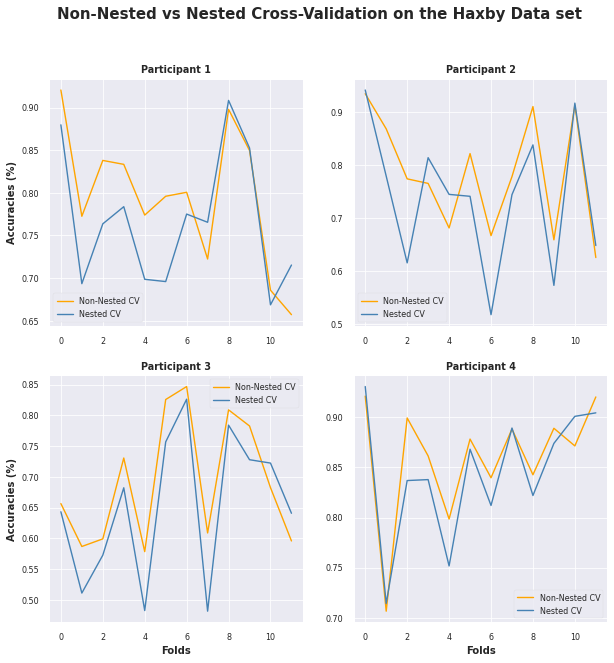

In [21]:
#import seaborn as sns
import seaborn as sns
sns.set_theme()
sns.set_context("paper")


plt.style.use('seaborn-paper')
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
fig.suptitle("Non-Nested vs Nested Cross-Validation on the Haxby Data set", fontsize = 15, fontweight='bold')

outer_scores_line, = axs[0, 0].plot(outer_scores[:,0], color='orange')
nested_line, = axs[0, 0].plot(nested_scores[:,0], color='steelblue')
axs[0, 0].legend([outer_scores_line, nested_line],
          ["Non-Nested CV", "Nested CV"])
axs[0, 0].set_title('Participant 1', fontweight = 'bold')
axs[0, 0].set_ylabel("Accuracies (%)", fontsize=10, fontweight='bold')

axs[0, 1].plot(outer_scores[:,1], color='orange')
axs[0, 1].plot(nested_scores[:,1], color='steelblue')
axs[0, 1].legend([outer_scores_line, nested_line],
          ["Non-Nested CV", "Nested CV"])
axs[0, 1].set_title('Participant 2', fontweight='bold')



axs[1, 0].plot(outer_scores[:,2], color='orange')
axs[1, 0].plot(nested_scores[:,2], color='steelblue')
axs[1, 0].legend([outer_scores_line, nested_line],
          ["Non-Nested CV", "Nested CV"])
axs[1, 0].set_title('Participant 3', fontweight='bold')
axs[1, 0].set_ylabel("Accuracies (%)", fontsize=10, fontweight='bold')
axs[1, 0].set_xlabel("Folds", fontsize=10, fontweight='bold')

axs[1, 1].plot(outer_scores[:,3], color='orange')
axs[1, 1].plot(nested_scores[:,3], color='steelblue')
axs[1, 1].legend([outer_scores_line, nested_line],
          ["Non-Nested CV", "Nested CV"])
axs[1, 1].set_title('Participant 4', fontweight='bold')
axs[1, 1].set_xlabel("Folds", fontsize=10, fontweight='bold')



plt.savefig("cross_val.png")
files.download("cross_val.png")